In [ ]:
import kagglehub

# Download dataset from Kagglehub
path = kagglehub.dataset_download("techsash/waste-classification-data")
print("Path to dataset files:", path)

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Define train and test paths (adjust according to your dataset structure)
train_path = os.path.join("C:/Users/Rathod ShashiVardhan/Documents/Projects", 'DATASET', 'TRAIN')
test_path = os.path.join("C:/Users/Rathod ShashiVardhan/Documents/Projects", 'DATASET', 'TEST')

print("Train path:", train_path)
print("Test path:", test_path)

Train path: C:/Users/Rathod ShashiVardhan/Documents/Projects\DATASET\TRAIN
Test path: C:/Users/Rathod ShashiVardhan/Documents/Projects\DATASET\TEST


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from glob import glob

# Additional libraries for evaluation
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

Loading R: 100%|██████████| 9999/9999 [01:54<00:00, 87.65it/s] 


Data shape: (22564, 2)
Label distribution: Counter({'O': 12565, 'R': 9999})


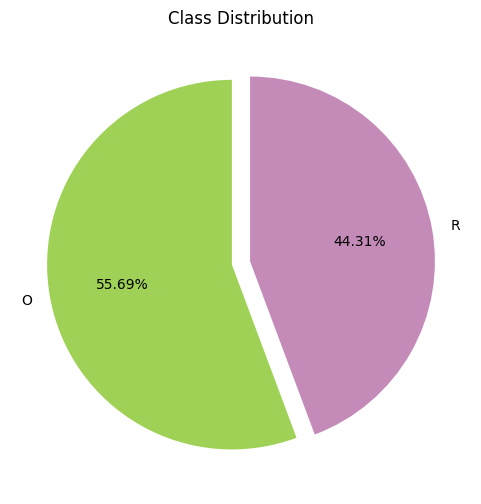

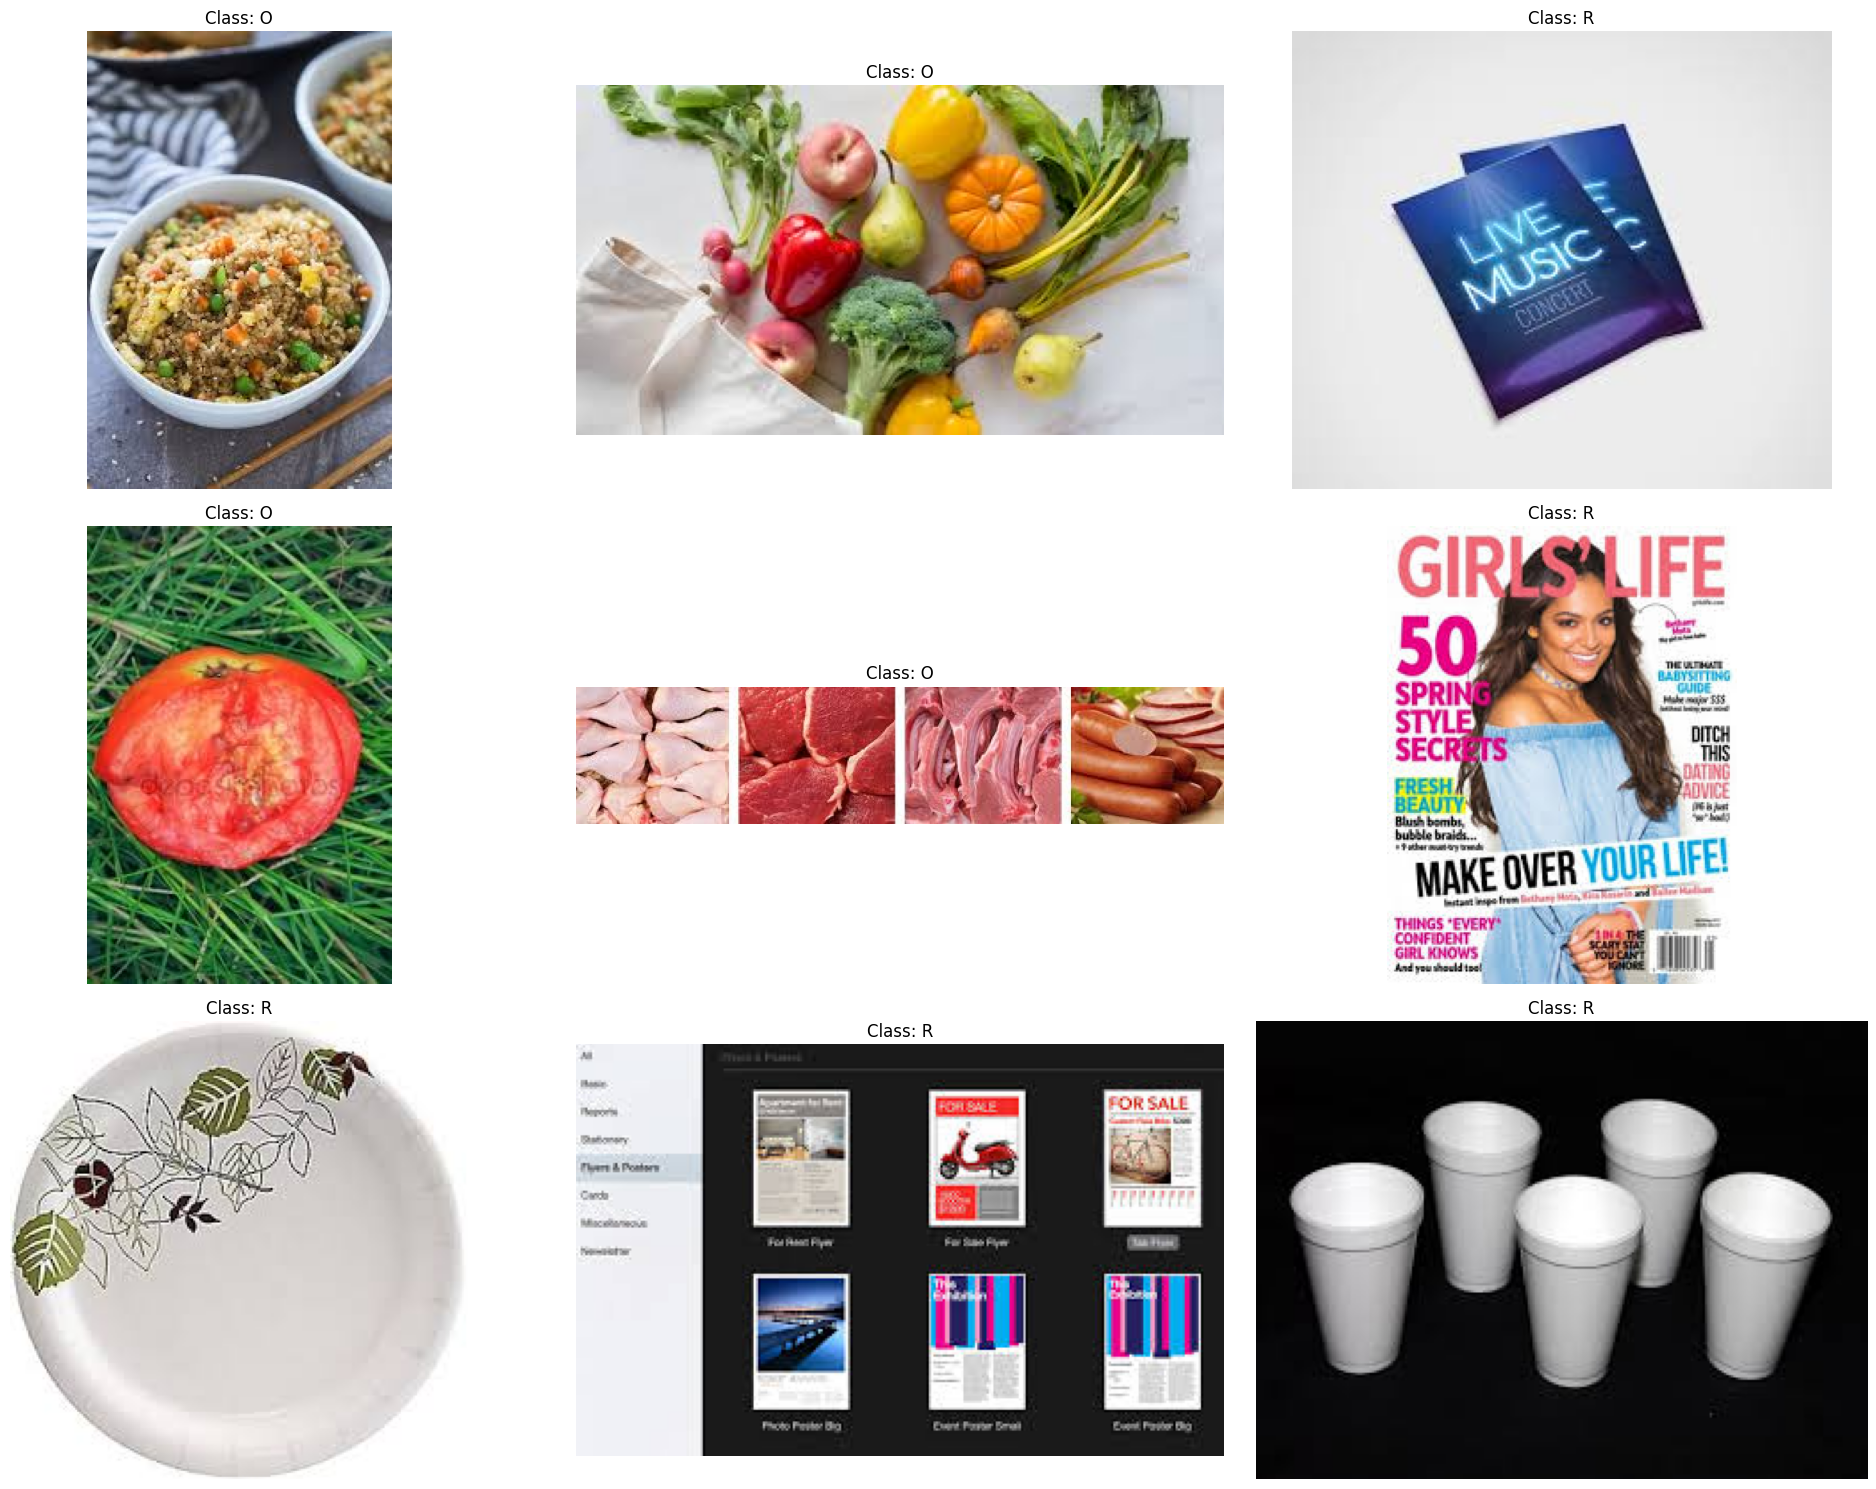

In [3]:
# Initialize lists to store images and labels
x_data = []
y_data = []

# Loop through each category folder in the train directory
for category in glob(os.path.join(train_path, '*')):
    for file in tqdm(glob(os.path.join(category, '*')), desc=f"Loading {os.path.basename(category)}"):
        img_array = cv2.imread(file)
        if img_array is not None:
            # Convert from BGR to RGB for proper color display
            img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
            x_data.append(img_array)
            y_data.append(os.path.basename(category))

# Create a DataFrame for easy visualization
data = pd.DataFrame({'image': x_data, 'label': y_data})
print("Data shape:", data.shape)

# Print class distribution
from collections import Counter
print("Label distribution:", Counter(y_data))

# Plot pie chart for class distribution
colors = ['#a0d157', '#c48bb8']
plt.figure(figsize=(6,6))
plt.pie(data.label.value_counts(),
        labels=data.label.value_counts().index,
        autopct='%0.2f%%',
        colors=colors,
        startangle=90,
        explode=[0.05] * len(data.label.value_counts()))
plt.title("Class Distribution")
plt.show()

# Display sample images from the dataset
plt.figure(figsize=(20, 15))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    index = np.random.randint(len(data))
    plt.imshow(data.image[index])
    plt.title(f"Class: {data.label[index]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [4]:
# Training data augmentation to improve generalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

# For validation/test data, we only rescale
test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 64
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode="categorical"
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode="categorical",
    shuffle=False  # Ensures order for evaluation
)


Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [5]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout

# Load MobileNetV2 with pre-trained ImageNet weights.
# Set include_top=False to remove the original classification layers.
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model to keep its weights unchanged during training.
base_model.trainable = False

# Build the new model by stacking our custom classifier on top of the base.
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # Two classes: for example, "Recyclable" and "Organic"
])

# Compile the model with categorical_crossentropy since we use one-hot encoded labels.
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    16,056,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,315,074 (69.87 MB)

 Trainable params: 16,057,090 (61.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [6]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Set up callbacks to help speed convergence and prevent overfitting.
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6),
    ModelCheckpoint('waste_classification_best.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
]

# Adjust the number of epochs as needed. With transfer learning, fewer epochs are typically needed.
epochs = 1  # You can start with 10 epochs; increase if necessary.
hist = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator,
    callbacks=callbacks
)


353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8647 - loss: 1.2068
Epoch 1: val_accuracy improved from -inf to 0.83526, saving model to waste_classification_best.h5


353/353 ━━━━━━━━━━━━━━━━━━━━ 827s 2s/step - accuracy: 0.8648 - loss: 1.2049 - val_accuracy: 0.8353 - val_loss: 0.3791 - learning_rate: 0.0010


40/40 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step
Classification Report:
              precision    recall  f1-score   support

           O       0.78      0.98      0.87      1401
           R       0.96      0.66      0.78      1112

    accuracy                           0.84      2513
   macro avg       0.87      0.82      0.82      2513
weighted avg       0.86      0.84      0.83      2513



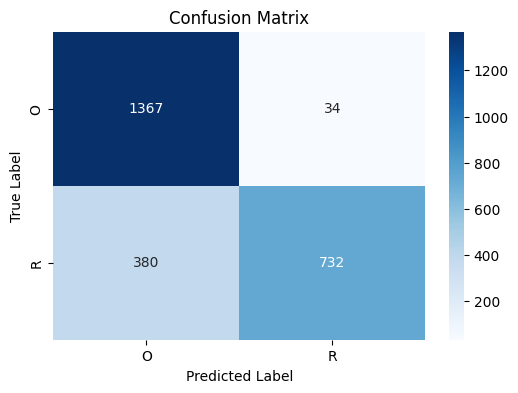

In [8]:
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Ensure the test generator is reset so predictions correspond to true labels.
test_generator.reset()
predictions = model.predict(test_generator, verbose=1)
predicted_class_indices = np.argmax(predictions, axis=1)
true_class_indices = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Print the classification report.
print("Classification Report:")
print(classification_report(true_class_indices, predicted_class_indices, target_names=class_labels))

# Plot a confusion matrix.
cm = confusion_matrix(true_class_indices, predicted_class_indices)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title("Confusion Matrix")
plt.show()


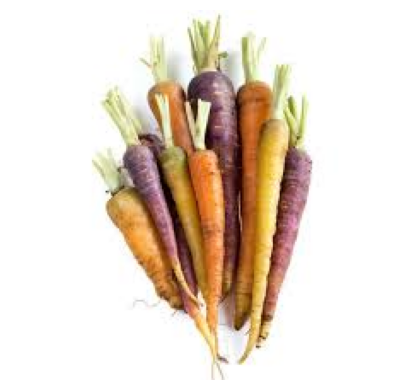

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
Prediction: Organic Waste with confidence: 75.38%


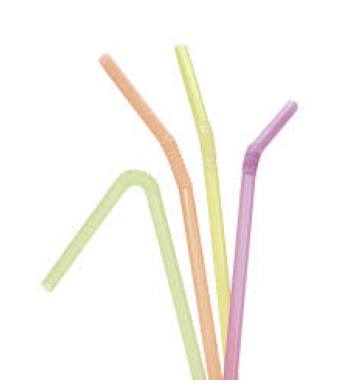

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
Prediction: Recyclable Waste with confidence: 59.91%


In [22]:
def predict_func(img):
    import cv2
    import numpy as np
    import matplotlib.pyplot as plt

    # Display the input image.
    plt.figure(figsize=(6, 4))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Preprocess the image: resize and normalize.
    img_resized = cv2.resize(img, (224, 224))
    img_array = img_resized.astype("float32") / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict class probabilities.
    prediction = model.predict(img_array)[0]
    result_idx = np.argmax(prediction)
    confidence = prediction[result_idx] * 100

    label = "Recyclable Waste" if result_idx == 0 else "Organic Waste"
    print(f"Prediction: {label} with confidence: {confidence:.2f}%")

# Test the prediction function on sample images.
import os
import cv2

test_img_path_1 = os.path.join(test_path, "O", "O_12574.jpg")
test_img_path_2 = os.path.join(test_path, "R", "R_10705.jpg")

test_img1 = cv2.imread(test_img_path_1)
predict_func(test_img1)

test_img2 = cv2.imread(test_img_path_2)
predict_func(test_img2)
